# Анализ пользовательского взаимодействия с карточками статей Яндекс.Дзен


Создадим коннекцию к базе и сохраним таблицу в переменную `dash_visits`.

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

query = '''
        SELECT * 
        FROM dash_visits
        '''

dash_visits = pd.io.sql.read_sql(query, con = engine)

Посмотрим на таблицу.

In [2]:
dash_visits.sample(5)

,record_id,item_topic,source_topic,age_segment,dt,visits
25569,1066166,Семья,Знаменитости,18-25,2019-09-24 18:54:00,11
16558,1057155,Отношения,История,18-25,2019-09-24 18:53:00,1
12268,1052865,Культура,Интерьеры,36-40,2019-09-24 18:57:00,3
27448,1068045,Скандалы,Семья,18-25,2019-09-24 19:00:00,10
18640,1059237,Подборки,Россия,36-40,2019-09-24 18:56:00,13


Каждую карточку определяют её тема `item_topic` и источник `source_topic` (у него тоже есть тема). Примеры тем: «Красота и здоровье», «Россия», «Путешествия».

Пользователей системы характеризует возрастная категория `age_segment`. Скажем, «26-30» или «45+».

Есть три способа взаимодействия пользователей с системой:
- Карточка отображена для пользователя (*show*);
- Пользователь кликнул на карточку (*click*);
- Пользователь просмотрел статью карточки (*view*);

в этой агрегированной таблице мы рассматриваем суммарные визиты — `visits`.

Ознакомимся с общей информацией о данных в таблице.

In [3]:
dash_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB


Пропусков нет, все типы данных соответствуют значениям.

In [4]:
display(f'Количество явных дубликатов: {dash_visits.duplicated().sum()}')

'Количество явных дубликатов: 0'

Проверим данные в строковых столбцах.

In [5]:
for col in ['item_topic', 'source_topic', 'age_segment']:
    display(f'Значения колонки {col}:')    
    display(dash_visits[col].value_counts())
    print()

'Значения колонки item_topic:'

Отношения             1536
Интересные факты      1535
Наука                 1505
Подборки              1456
Полезные советы       1424
Общество              1422
Россия                1385
История               1363
Семья                 1287
Путешествия           1247
Деньги                1234
Женщины               1230
Дети                  1229
Туризм                1206
Здоровье              1203
Красота               1193
Культура              1160
Юмор                  1129
Искусство             1119
Рассказы              1109
Психология            1056
Скандалы              1023
Знаменитости           976
Женская психология     914
Шоу                    804
Name: item_topic, dtype: int64

'Значения колонки source_topic:'

Семейные отношения    1822
Россия                1687
Знаменитости          1650
Полезные советы       1578
Путешествия           1563
Кино                  1505
Дети                  1459
История               1437
Семья                 1405
Одежда                1379
Здоровье              1243
Искусство             1228
Авто                  1077
Психология            1055
Сад и дача            1036
Политика              1024
Спорт                 1007
Сделай сам             995
Ремонт                 985
Деньги                 973
Еда                    912
Интерьеры              809
Строительство          758
Музыка                 750
Технологии             741
Финансы                667
Name: source_topic, dtype: int64

'Значения колонки age_segment:'

18-25    7056
26-30    5875
31-35    5552
36-40    5105
41-45    3903
45+      3254
Name: age_segment, dtype: int64

Нет ничего подозрительного.

In [6]:
display(f'Временной интервал записей таблицы: с {dash_visits["dt"].min()} до {dash_visits["dt"].max()}')

'Временной интервал записей таблицы: с 2019-09-24 18:28:00 до 2019-09-24 19:00:00'

Всего полчаса вечером 24-ого сентября 2019.

И, наконец, посмотрим на разброс значений в колонке `visits`.

In [7]:
dash_visits['visits'].describe()

count    30745.000000
mean        10.089673
std         19.727601
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        371.000000
Name: visits, dtype: float64

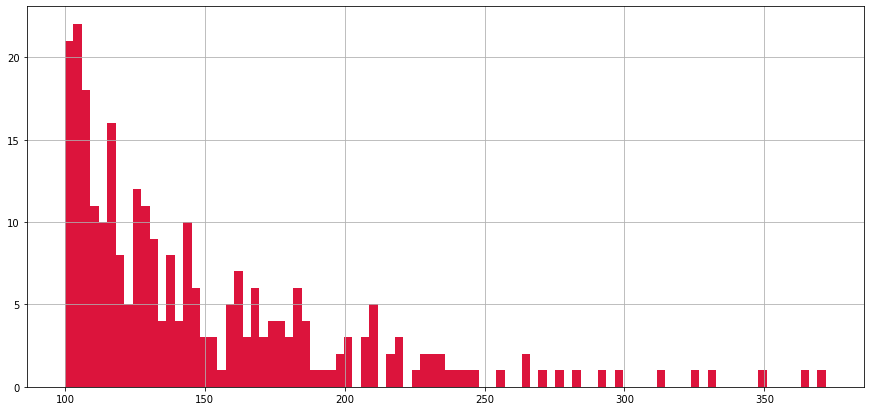

In [8]:
dash_visits['visits'].hist(bins=90, range=(100,372), figsize=(15,7), color='crimson');

У распределения длинный хвост, уходящий вправо — среднее значительно отличается от медианы. Но, похоже, что большие значения всё-таки не аномалии.

Стало быть, данные в порядке — можно выгружать таблицу в файл `dash_visits.csv`.

In [ ]:
dash_visits.to_csv('dash_visits.csv', index=False)